In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer 

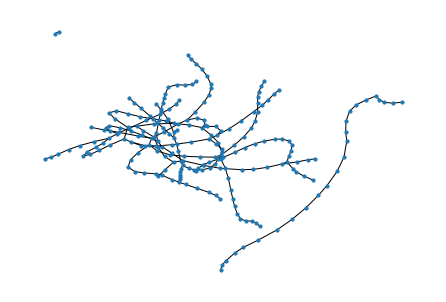

In [2]:
#读取爬虫爬的地铁站
stop = gpd.read_file(r'/Users/yuqing/Nutstore Files/我的坚果云/python_new/2022/矫仟慧-地铁建模/gis/南京地铁站点.json')
#很多名字不对，需要跟数据对应
stop.loc[stop['stationnames'] == '南京林业大学·新庄', 'stationnames'] = '南京林业大学新庄'
stop.loc[stop['stationnames'] == '草场门·南艺·二师', 'stationnames'] = '南艺二师草场门'
stop.loc[stop['stationnames'] == '南医大·江苏经贸学院', 'stationnames'] = '南医大江苏经贸学院'
stop.loc[stop['stationnames'] == '浮桥·华海3C广场', 'stationnames'] = '浮桥'
stop.loc[stop['stationnames'] == '河海大学·佛城西路', 'stationnames'] = '河海大学佛城西路'
stop.loc[stop['stationnames'] == '徐庄·苏宁总部', 'stationnames'] = '苏宁总部徐庄'
stop.loc[stop['stationnames'] == '临江·青奥体育公园', 'stationnames'] = '临江青奥体育公园'
stop.loc[stop['stationnames'] == '兰花塘·南京科学城', 'stationnames'] = '兰花塘'

#读取爬虫爬的地铁站
line = gpd.read_file(r'/Users/yuqing/Nutstore Files/我的坚果云/python_new/2022/矫仟慧-地铁建模/gis/南京地铁线路.json')
line['speed'] = 36 #地铁运行速度36km/h
line['stoptime'] = 0.5 #停站时间（30s）

import networkx as nx
# 用TransBigData构建地铁拓扑模型
G = tbd.metro_network(line,stop, transfertime=10)
nx.draw(G,node_size=10)

In [22]:
#输入OD，获取出行时长
def get_shortest_path_traveltime(ostation,dstation,G,stop):
    '''
    Obtain the travel time of shortest path from the metro nextwork

    Parameters
    -------
    
    ostation : str
        O station name
    dstation : str
        D station name
    G : networkx.classes.graph.Graph
        metro network
    stop : DataFrame
        metro stop dataframe

    Returns
    -------
    traveltime : float
        metro travel time
    '''
    o = stop[stop['stationnames']==ostation]['line'].iloc[0]+ostation
    d = stop[stop['stationnames']==dstation]['line'].iloc[0]+dstation
    return nx.shortest_path_length(G,source=o,target=d,weight='weight')
def get_shortest_path(ostation,dstation,G,stop):
    '''
    Obtain the travel path of shortest path from the metro nextwork

    Parameters
    -------
    
    ostation : str
        O station name
    dstation : str
        D station name
    G : networkx.classes.graph.Graph
        metro network
    stop : DataFrame
        metro stop dataframe

    Returns
    -------
    path : list
        travel path: list of station names
    '''
    o = stop[stop['stationnames']==ostation]['line'].iloc[0]+ostation
    d = stop[stop['stationnames']==dstation]['line'].iloc[0]+dstation
    return nx.shortest_path(G,source=o,target=d,weight='weight')

def get_k_shortest_paths(ostation, dstation, k, G, stop):
    '''
    Obtain the k th shortest paths from the metro nextwork

    Parameters
    -------
    
    ostation : str
        O station name
    dstation : str
        D station name
    k : int
        the k th shortest paths
    G : networkx.classes.graph.Graph
        metro network
    stop : DataFrame
        metro stop dataframe

    Returns
    -------
    path : list
        travel path: list of travel paths
    '''
    o = stop[stop['stationnames'] == ostation]['line'].iloc[0]+ostation
    d = stop[stop['stationnames'] == dstation]['line'].iloc[0]+dstation
    return list(
        islice(nx.shortest_simple_paths(G, o, d, weight='weight'), k)
    )


In [3]:
tbd.get_k_shortest_paths('迈皋桥','玄武门',20,G,stop)

[['地铁1号线迈皋桥', '地铁1号线红山动物园', '地铁1号线南京站', '地铁1号线新模范马路', '地铁1号线玄武门'],
 ['地铁1号线迈皋桥',
  '地铁1号线红山动物园',
  '地铁1号线南京站',
  '地铁3号线南京站',
  '地铁3号线南京林业大学新庄',
  '地铁3号线鸡鸣寺',
  '地铁4号线鸡鸣寺',
  '地铁4号线鼓楼',
  '地铁1号线鼓楼',
  '地铁1号线玄武门'],
 ['地铁1号线迈皋桥',
  '地铁1号线红山动物园',
  '地铁1号线南京站',
  '地铁3号线南京站',
  '地铁3号线南京林业大学新庄',
  '地铁3号线鸡鸣寺',
  '地铁3号线浮桥',
  '地铁3号线大行宫',
  '地铁2号线大行宫',
  '地铁2号线新街口',
  '地铁1号线新街口',
  '地铁1号线珠江路',
  '地铁1号线鼓楼',
  '地铁1号线玄武门'],
 ['地铁1号线迈皋桥',
  '地铁1号线红山动物园',
  '地铁1号线南京站',
  '地铁3号线南京站',
  '地铁3号线南京林业大学新庄',
  '地铁3号线鸡鸣寺',
  '地铁3号线浮桥',
  '地铁3号线大行宫',
  '地铁3号线常府街',
  '地铁3号线夫子庙',
  '地铁3号线武定门',
  '地铁3号线雨花门',
  '地铁3号线卡子门',
  '地铁10号线二期卡子门',
  '地铁10号线二期雨花台',
  '地铁10号线二期共青团路',
  '地铁10号线二期安德门',
  '地铁1号线安德门',
  '地铁1号线中华门',
  '地铁1号线三山街',
  '地铁1号线张府园',
  '地铁1号线新街口',
  '地铁1号线珠江路',
  '地铁1号线鼓楼',
  '地铁1号线玄武门'],
 ['地铁1号线迈皋桥',
  '地铁1号线红山动物园',
  '地铁1号线南京站',
  '地铁3号线南京站',
  '地铁3号线南京林业大学新庄',
  '地铁3号线鸡鸣寺',
  '地铁3号线浮桥',
  '地铁3号线大行宫',
  '地铁3号线常府街',
  '地铁3号线夫子庙',
  '地铁3号线武定门',
  '地铁3号线雨花门',
  '地铁3号线卡子门',
  '地铁3号线大明路',
  '地铁3号线明发广场',

In [4]:
tbd.get_shortest_path('迈皋桥','玄武门',G,stop)


['地铁1号线迈皋桥', '地铁1号线红山动物园', '地铁1号线南京站', '地铁1号线新模范马路', '地铁1号线玄武门']

In [5]:
tbd.get_shortest_path_traveltime('迈皋桥','玄武门',G,stop)

11.750726358470338